# Linear regression using gradient descent

The optimization method of gradient descent can be used to solve regression problems. The gradient descent learning routine (algorithm) finds the optimal parameters for a linear model by finding the global minimum of a differentiable cost function. Let's fit a linear regression model—from scratch in Python—using two flavors of gradient descent: batch gradient descent and stochastic gradient descent.

In [1052]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from pprint import pprint

sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline

## Load dataset

Let's use the Boston house-price dataset, wherein the target values are the median values of owner-occupied homes in thousands of dollars.

In [1053]:
data_bunch = load_boston()
X_bunch = data_bunch.data
y_bunch = data_bunch.target.reshape((len(data_bunch.target),1))
input_data = np.hstack((X_bunch,y_bunch))
col_names = np.append(data_bunch.feature_names, 'MEDV')

In [1054]:
# Construct DataFrame
df = pd.DataFrame(data=input_data, columns=col_names)
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [1055]:
# Define the features, X, and target values, y
X = df.drop(["MEDV"], axis="columns")
y = df[["MEDV"]]
print("Input dataset has {} samples and {} features".format(X.shape[0], X.shape[1]))

Input dataset has 506 samples and 13 features


In [1056]:
# Identify the continuous vs. categorical features
colnames_num = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
colnames_cat = ['CHAS', 'RAD']

## Do train-test split of inputs

In [1057]:
# Split input data into random train (75%) and test (25%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # random state fixed for reproducible output
# Copy the train and test subsets to avoid the SettingWithCopyWarning in pandas
X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
print("Training dataset has {} samples".format(X_train.shape[0]))
print("Testing dataset has {} samples".format(X_test.shape[0]))

Training dataset has 379 samples
Testing dataset has 127 samples


## Clean dataset

Impute the missing values using either the median value (for continuous features) or the most frequent value (for categorical features) along each column.

In [1058]:
# For continuous features, replace missing values if necessary
numcols_nancounts = X_train[colnames_num].isna().sum(axis="rows").to_dict()
numcols_nans = [colname for colname, nancount in numcols_nancounts.items() if nancount > 0]
if len(numcols_nans):
    imp_num = SimpleImputer(missing_values=np.nan, strategy="median")
    imp_num_data = imp_num.fit_transform(X_train[numcols_nans].to_numpy())
    X_train[numcols_nans] = imp_num_data
print("Numerical data has {} missing values".format(X_train[colnames_num].isna().sum(axis="rows").sum(axis="rows")))

Numerical data has 0 missing values


In [1059]:
# For categorical features, replace missing values if necessary
catcols_nancounts = X_train[colnames_cat].isna().sum(axis="rows").to_dict()
catcols_nans = [colname for colname, nancount in catcols_nancounts.items() if nancount > 0]
if len(catcols_nans):
    imp_cat = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    imp_cat_data = imp_cat.fit_transform(X_train[catcols_nans].to_numpy())
    X_train[catcols_nans] = imp_cat_data
print("Categorical data has {} missing values".format(X_train[colnames_cat].isna().sum(axis="rows").sum(axis="rows")))

Categorical data has 0 missing values


## Engineer features as needed

Standardize the continuous features by centering (removing the mean value) and scaling (dividing by the standard deviation) the data.

In [1060]:
# Center and scale the numerical data
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(X_train[colnames_num].to_numpy())
X_train[colnames_num] = scaled_num_data
X_train.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
502,-0.401551,-0.491062,0.103396,0.0,0.160851,-0.197704,0.281472,-0.719664,1.0,-0.780941,1.179226,0.431311,-0.533076
172,-0.391526,-0.491062,-1.044240,0.0,-0.374549,-0.995948,0.699332,-0.575163,5.0,-0.645056,-0.878189,0.431311,0.242448
80,-0.401993,0.574508,-0.926273,0.0,-1.088414,0.686481,-1.248317,0.738082,4.0,-0.733677,0.244037,0.431311,-1.057004
46,-0.386270,-0.491062,-0.627712,0.0,-0.901449,-0.684225,-1.255400,0.597468,3.0,-1.017264,-0.270316,0.431311,0.167799
318,-0.363451,-0.491062,-0.192251,0.0,-0.085603,0.183937,-0.054940,-0.136697,4.0,-0.597791,-0.036519,0.412425,-0.356129


## Select the most relevant features

First, remove all features with zero variance. Second, select the best feature based on the correlation between each regressor and the target. The selection of one feature simplifies the visualization of the gradient descent optimization technique.

In [1061]:
# Remove all zero-variance features
zeroVar_selector = VarianceThreshold()
zeroVar_selector.fit_transform(X_train.to_numpy())
bool_nonzeroVar = zeroVar_selector.get_support()
X_train = X_train.loc[:,bool_nonzeroVar]
print("{} zero-variance features are removed".format(np.sum(~bool_nonzeroVar)))

0 zero-variance features are removed


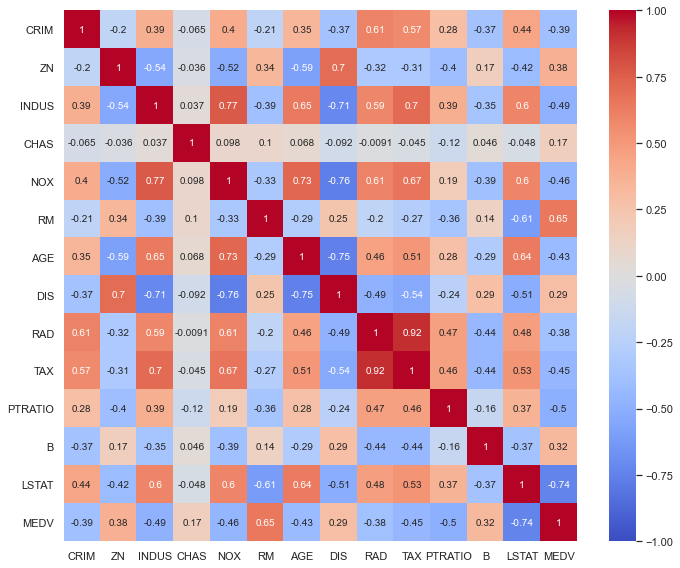

In [1062]:
# Compute pairwise correlation of the columns,
# and plot a heatmap for the correlation matrix
X_y_train_data = np.hstack((X_train.to_numpy(),y_train.to_numpy()))
X_y_train_col_names = np.append(X_train.columns, y_train.columns)
X_y_train = pd.DataFrame(data=X_y_train_data, columns=X_y_train_col_names)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(X_y_train.corr(method="pearson"), vmin=-1, vmax=1, cmap="coolwarm", annot=True)
plt.tight_layout()
plt.show()

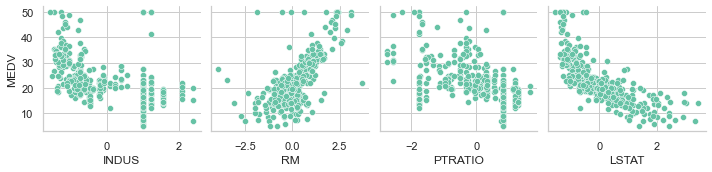

In [1063]:
# Plot pairwise relationships in the dataset as a matrix of scatter plots
# for the subset of features showing strong correlation with the target
sns.pairplot(X_y_train, x_vars=["INDUS","RM","PTRATIO","LSTAT"], y_vars=["MEDV"])
plt.tight_layout()
plt.show()

In [1064]:
# Remove all but the highest scoring feature
kBest_selector = SelectKBest(f_regression, k=1)
kBest_selector.fit_transform(X_train.to_numpy(), np.ravel(y_train.to_numpy()))
bool_kBest = kBest_selector.get_support()
colnames_kBest = X_train.columns[bool_kBest].tolist()
X_train = X_train.loc[:,bool_kBest]
print("{} is the best feature based on its correlation with the target".format(colnames_kBest[0]))
X_train.head(5)

LSTAT is the best feature based on its correlation with the target


,LSTAT
502,-0.533076
172,0.242448
80,-1.057004
46,0.167799
318,-0.356129


## Fit linear regression model using gradient descent

Our goal is to fit a linear model $f(x) = w^{T}x + b$ with weights $w$ and intercept $b$ by minimizing the training error between the predicted target values $\hat{y}$ and the observed target values $y$, using the gradient descent optimization technique. The cost function $J$ that measures the model-data misfit across $n$ training samples is given by:

$J(w, b) = \frac{1}{n} \sum \limits _{i=1} ^{n} L(f(x^{(i)}), y^{(i)})$,

where $L(f(x^{(i)}), y^{(i)})$ is the loss function computed on the $i$th training sample. The squared error loss function, $L(f(x^{(i)}), y^{(i)}) = \frac{1}{2}(f(x^{(i)}) - y^{(i)})^{2}$, is widely utilized for regression problems.

In __batch gradient descent__, the gradient of the cost function is estimated using all training examples and the model parameters are updated once per epoch. In contrast, __stochastic gradient descent__ approximates the true gradient by considering one training example at a time, with the model parameters updated along the way.

The weight $w_{j}$ that is assigned to the $j$th feature $x_{j}$ is updated as:

$w_{j} := w_{j} - \alpha \frac{\partial J}{\partial w_{j}}$,

where $\frac{\partial J}{\partial w_{j}} = \frac{1}{n} \sum \limits _{i=1} ^{n} (f(x^{(i)}) - y^{(i)})x_{j}^{(i)}$ is the partial derivative of the cost function $J$ with respect to $w_{j}$.

The intercept $b$ is updated as:

$b := b - \alpha \frac{\partial J}{\partial b}$,

where $\frac{\partial J}{\partial b} = \frac{1}{n} \sum \limits _{i=1} ^{n} (f(x^{(i)}) - y^{(i)})$ is the partial derivative of the cost function $J$ with respect to $b$.

The constant learning rate $\alpha$ controls the step size in the parameter space.

In [1065]:
# Implement a first-order gradient descent learning routine
def GD_algorithm(X, y, solver=None, max_iter=None, alpha=None, tol=None, n_iter_no_improve=None):
    # Specify the gradient descent algorithm to use in the optimization problem
    # (i.e., the way to train the model)
    # It must be one of "BGD" (Batch Gradient Descent) or "SGD" (Stochastic Gradient Descent)
    if solver == None:
        solver = "SGD" # if none is given, "SGD" will be used
    
    # Set the default hyperparameters of the algorithm
    if max_iter == None:
        max_iter = 1000 # the maximum number of iterations over the training data (aka epochs)
    if alpha == None:
        alpha = 0.01 # the constant learning rate (must be between 0 and 1)
    if tol == None:
        tol = 0.001 # the absolute tolerance used in the early stopping criterion
    if n_iter_no_improve == None:
        n_iter_no_improve = 5 # the number of iterations with no improvement before stopping the algorithm
        
    # Initialize the weight vector (i.e., the weights assigned to the features) to zero
    n_feat = X.shape[1]
    w = np.zeros((n_feat, 1))
    # Initialize the intercept term to zero
    b = 0
    
    # Convert any pandas DataFrame or Series to a NumPy array
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y.to_numpy().reshape((len(y),1))
        
    # Terminate training when the cost function J is not improving
    # by at least tolerance tol for n_iter_no_improve consecutive epochs
    best_J = 1_000_000_000_000
    iter_no_improve_count = 0
    
    # Fit linear model using Batch Gradient Descent
    # Here, the algorithm updates the weights and intercept once per epoch
    if solver == "BGD":
        # Perform max_iter iterations of gradient descent on training samples
        for idx_iter in range(max_iter):
            # Predict the target values for all training samples
            yhat = np.dot(X, w) + b
            # Calculate the average values of dJ/dw and dJ/db across all training samples
            dw = np.mean((yhat - y)*X, axis=0)
            db = np.mean(yhat - y)
            # Update the weights and intercept
            w -= alpha*dw.reshape(w.shape)
            b -= alpha*db
            # Calculate the mean squared error
            J = np.mean(0.5*((yhat - y)**2))
            # Evaluate the stopping criterion once per epoch
            if J > (best_J - tol):
                iter_no_improve_count += 1
            else:
                iter_no_improve_count = 0
                best_J = J
            # Stop the algorithm when J > (best_J - tol)
            # for n_iter_no_improve consecutive epochs
            if iter_no_improve_count == n_iter_no_improve:
                break
                
    # Fit linear model using Stochastic Gradient Descent
    # Here, the algorithm iterates over the training examples
    # and for each example updates the weights and intercept
    elif solver == "SGD":
        # Perform max_iter iterations of gradient descent on training samples
        for idx_iter in range(max_iter):
            # Iterate over the training samples
            for i in range(len(X)):
                x_i, y_i = X[i,:], y[i].item()
                # Predict the target value for the i-th training sample
                yhat_i = (np.dot(x_i, w) + b).item()
                # Estimate dJ/dw and dJ/db based on the i-th training sample
                dw_i = (yhat_i - y_i)*x_i
                db_i = yhat_i - y_i
                # Update the weights and intercept
                w -= alpha*dw_i.reshape(w.shape)
                b -= alpha*db_i
            # Predict the target values for all training samples
            yhat = np.dot(X, w) + b
            # Calculate the mean squared error
            J = np.mean(0.5*((yhat - y)**2))
            # Evaluate the stopping criterion once per epoch
            if J > (best_J - tol):
                iter_no_improve_count += 1
            else:
                iter_no_improve_count = 0
                best_J = J
            # Stop the algorithm when J > (best_J - tol)
            # for n_iter_no_improve consecutive epochs
            if iter_no_improve_count == n_iter_no_improve:
                break
                
    n_iter = idx_iter + 1 # the actual number of iterations before reaching the stopping criterion
    
    return w, b, J, n_iter

In [1066]:
# Fit a linear model to the training data using gradient descent
optim_w__BGD, optim_b__BGD, min_j__BGD, n_iter__BGD = GD_algorithm(X_train, y_train, solver="BGD", max_iter=1000, alpha=0.01, tol=0.001, n_iter_no_improve=5)
coeffs_J_dict__BGD = {(optim_w__BGD.item(), optim_b__BGD): min_j__BGD}
print("After {} epochs of batch grad. descent, model parameters w1={:.2f} and b={:.2f} minimize the cost function J={:.2f}".format(n_iter__BGD, optim_w__BGD.item(), optim_b__BGD, min_j__BGD))
optim_w__SGD, optim_b__SGD, min_j__SGD, n_iter__SGD = GD_algorithm(X_train, y_train, solver="SGD", max_iter=1000, alpha=0.01, tol=0.0001, n_iter_no_improve=10)
coeffs_J_dict__SGD = {(optim_w__SGD.item(), optim_b__SGD): min_j__SGD}
print("After {} epochs of stochastic grad. descent, model parameters w1={:.2f} and b={:.2f} minimize the cost function J={:.2f}".format(n_iter__SGD, optim_w__SGD.item(), optim_b__SGD, min_j__SGD))

After 515 epochs of batch grad. descent, model parameters w1=-6.55 and b=22.22 minimize the cost function J=18.00
After 12 epochs of stochastic grad. descent, model parameters w1=-6.88 and b=22.38 minimize the cost function J=18.03


In [1067]:
# Predict the target values using the linear model fitted via gradient descent
coeffs_J_dict = {**coeffs_J_dict__BGD, **coeffs_J_dict__SGD}
optim_w1, optim_b = min(coeffs_J_dict, key=coeffs_J_dict.get)
min_j = coeffs_J_dict[(optim_w1, optim_b)]
y_pred = X_train*optim_w1 + optim_b

In [1068]:
# Predict the target values using the linear regressors in scikit-learn
skl_reg_names = ["sklearn OLS linear regression", "sklearn linear regression with SGD"]
skl_regs = [LinearRegression(), SGDRegressor(loss="squared_loss", penalty=None, max_iter=1000, tol=0.001, shuffle=False, learning_rate="constant", eta0=0.01, n_iter_no_change=5)]
skl_y_preds = []
for skl_reg in skl_regs:
    skl_reg.fit(X_train.to_numpy(), np.ravel(y_train.to_numpy()))
    skl_y_preds.append(skl_reg.predict(X_train.to_numpy()))

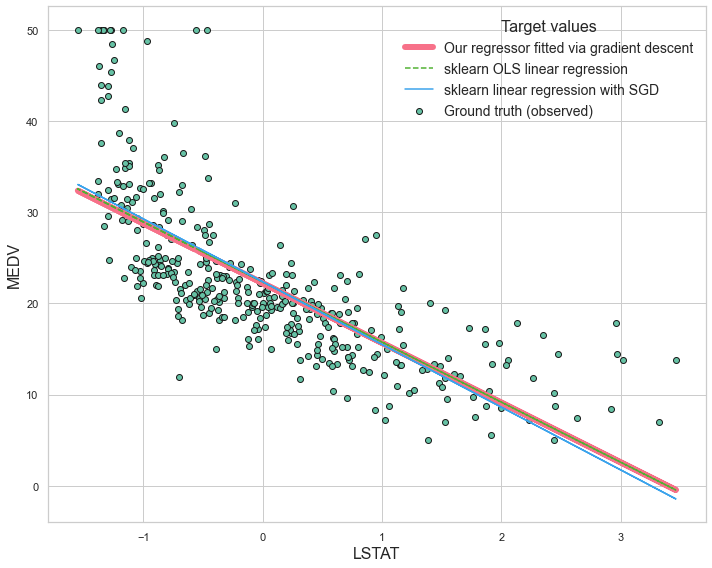

In [1069]:
# Compare our model's performance against the sklearn regressors
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_train, y_train, marker="o", edgecolors="k", label="Ground truth (observed)")
line_palette = iter(sns.husl_palette(1+len(skl_regs)))
ax.plot(X_train, y_pred, color=next(line_palette), linestyle="solid", linewidth=6, label="Our regressor fitted via gradient descent")
for skl_y_pred, skl_reg_name, line_style in zip(skl_y_preds, skl_reg_names, ["dashed", "solid"]):
    ax.plot(X_train, skl_y_pred, color=next(line_palette), linestyle=line_style, label=skl_reg_name)
ax.set_xlabel(X_train.columns.to_list()[0], fontsize=16)
ax.set_ylabel(y_train.columns.to_list()[0], fontsize=16)
ax.legend(loc="upper right", fontsize=14, frameon=False, title="Target values", title_fontsize=16)
plt.tight_layout()
plt.show()

## Visualize the cost function of two model parameters

The minimum of the cost function $J(w_{1}, b)$ is reached after performing epochs of gradient descent on the training samples. Now let's create a 3-D surface plot of the cost function, which requires evaluating the cost function over a rectangular grid in 2-D parameter space.

In [1070]:
# Evaluate the cost function J at the input parameter values
def compute_J(x1, y, w1_in, b_in):
    # Predict the target values for all training samples
    yhat = w1_in*x1 + b_in
    # Calculate the mean squared error
    J = np.mean(0.5*((yhat - y)**2))
    return J

In [1071]:
# Create a 2-D grid with uniformly spaced parameter points
w1_vec = np.arange(optim_w1-20, optim_w+20, 0.25)
b_vec = np.arange(optim_b-20, optim_b+20, 0.25)
W1_mat, B_mat = np.meshgrid(w1_vec, b_vec)
# Evaluate the cost function at all points in the parameter space
j_vec = np.array([compute_J(X_train.to_numpy(), y_train.to_numpy(), w1_pt, b_pt) for w1_pt, b_pt in zip(np.ravel(W1_mat), np.ravel(B_mat))])
J_mat = j_vec.reshape(W_mat.shape)

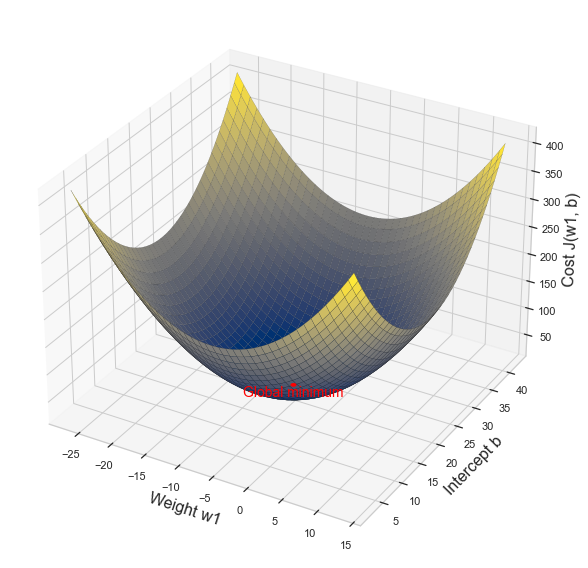

In [1072]:
# Plot the cost function J(w1, b) over the 2-D grid
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
ax.plot_surface(W_mat, B_mat, J_mat, cmap="cividis", linewidth=0.125, edgecolors="k", antialiased=True)
# Annotate the global minimum of the cost function
p = Circle((optim_w1, optim_b), radius=0.325, facecolor="red", edgecolor="red")
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=min_j, zdir="z")
ax.text(optim_w1, optim_b, min_j, "Global minimum", horizontalalignment="center", verticalalignment="top", fontsize=14, color="red")
ax.set_xlabel("Weight w1", fontsize=16)
ax.set_ylabel("Intercept b", fontsize=16)
ax.set_zlabel("Cost J(w1, b)", fontsize=16)
plt.tight_layout()
plt.show()